In [1]:
import os
import numpy as np
from tqdm import tqdm
from types import SimpleNamespace
from utils import *
from scipy.io import savemat
from utils import combine_idx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from generate_figs.plot_single_act import plot_avgAct_combined
from statannotations.Annotator import Annotator
from scipy.special import softmax


lr = 0.02
correct_only = True
save_plot = True

STIM_ST_TIME=45
TARG_ST_TIME=25

f_dirs = [
    "test_output_full_model",
    "test_output_noFeedback_model",
    "cutSpec_model",
    "cutNonspec_model",
]

data_dir = "dPCA_allTrial_data"
plt_dir = "dPCA_allTrial_plots"

Initializing Parameters...


In [208]:
# y_diff_df = pd.DataFrame()
# for f_dir in f_dirs:
#     model_type = f_dir.split("_")[-2]
#     for rep in tqdm(range(50)):
#         n = SimpleNamespace(
#             **load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep))
#         )
#         targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
#         y = softmax(n.y, axis=-1)
#         y_diff = np.subtract(y[-1, :, 0], y[-1, :, 1])
#         temp_df =  pd.DataFrame({"rep": rep, "trial": range(2048), "choice":n.choice,
#                                   "stim_dir":n.stim_dir, "stim_level":n.stim_level, 
#                                   "correct_idx": n.correct_idx, "targ_arrange": targ_arrange,
#                                   "y_diff": y_diff, "model_type": model_type})
#         y_diff_df = pd.concat([y_diff_df, temp_df])
# y_diff_df = y_diff_df.reset_index(drop=True)
# y_diff_df.to_csv(os.path.join(data_dir, "y_diff.csv"))

100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


In [215]:
# y_diff_time_df = pd.DataFrame()
# for f_dir in f_dirs:
#     model_type = f_dir.split("_")[-2]
#     for rep in tqdm(range(50)):
#         n = SimpleNamespace(
#             **load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep))
#         )
#         targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
#         y = softmax(n.y, axis=-1)
#         y_diff = np.subtract(y[:, :, 0], y[:, :, 1])
#         temp_df =  pd.DataFrame({"rep": rep, "trial": range(2048), "choice":n.choice,
#                                   "stim_dir":n.stim_dir, "stim_level":n.stim_level, 
#                                   "correct_idx": n.correct_idx, "targ_arrange": targ_arrange,
#                                   "model_type": model_type})
#         temp_df['y_dff'] = y_diff.T.tolist()
#         y_diff_time_df = pd.concat([y_diff_time_df, temp_df])
# y_diff_time_df = y_diff_time_df.reset_index(drop=True)
# y_diff_time_df.to_csv(os.path.join(data_dir, "y_diff_with_time.csv"))

100%|██████████| 50/50 [02:08<00:00,  2.58s/it]


In [216]:
y_diff_time_df

,rep,trial,choice,stim_dir,stim_level,correct_idx,targ_arrange,model_type,y_dff
0,0,0,0,315,b'M',True,True,full,"[0.0020689070224761963, -0.013056278228759766,..."
1,0,1,1,135,b'H',True,True,full,"[-0.005773633718490601, -0.009911417961120605,..."
2,0,2,1,135,b'Z',True,True,full,"[0.01824095845222473, 0.011532396078109741, 0...."
3,0,3,0,135,b'H',True,False,full,"[0.015537112951278687, 0.005901604890823364, -..."
4,0,4,0,135,b'L',True,False,full,"[0.0417557954788208, 0.059020280838012695, 0.0..."
...,...,...,...,...,...,...,...,...,...
409595,49,2043,1,315,b'H',True,False,cutNonspec,"[0.13467565178871155, 0.23622071743011475, 0.3..."
409596,49,2044,1,135,b'M',True,True,cutNonspec,"[0.0976693332195282, 0.15509271621704102, 0.19..."
409597,49,2045,1,315,b'L',True,False,cutNonspec,"[0.07285237312316895, 0.120867520570755, 0.132..."
409598,49,2046,0,315,b'L',True,True,cutNonspec,"[0.05679821968078613, 0.04982838034629822, 0.0..."


In [179]:
n.y.shape

(70, 2048, 2)

In [91]:
f_dir = f_dirs[2]
model_type = f_dir.split("_")[-2]
save_fn_sepStim = os.path.join(
    data_dir, model_type, "sepStim", "all_sepStim_acc.csv"
)
save_fn_sepSac = os.path.join(
    data_dir, model_type, "sepSac", "all_sepSac_acc.csv"
)

all_stim_df = pd.read_csv(save_fn_sepStim)
all_sac_df = pd.read_csv(save_fn_sepSac)

# all_sac_df[all_sac_df["total"]<2]

In [92]:
def calculate_bias_index(df):
    # calcualte the bias index for two target arrangement
    # bias > 0, bias to left, bias < 0, bias to right
    # bias > 0, bias to 135 direction, bias < 0, bias to 315 direction

    redL_df = df.loc[df['label'].str.contains('redL')].drop(columns=['Unnamed: 0']).sort_values(by=['rep', 'label']).reset_index(drop=True)
    greenL_df = df.loc[df['label'].str.contains('greenL')].drop(columns=['Unnamed: 0']).sort_values(by=['rep', 'label']).reset_index(drop=True)
    bias_idx = lambda x, y: (x-y)/(x+y)
    redL_df['bias'] = bias_idx(redL_df['total'], redL_df['total'].shift(1))[1::2]
    greenL_df['bias'] = bias_idx(greenL_df['total'], greenL_df['total'].shift(1))[1::2]
    bias_df = pd.concat([redL_df, greenL_df]).sort_values(by=['rep', 'label']).reset_index(drop=True)
    return bias_df

sac_bias_df = calculate_bias_index(all_sac_df)
stim_bias_df = calculate_bias_index(all_stim_df)

In [174]:
# for f_dir in f_dirs:
f_dir = f_dirs[2]
model_type = f_dir.split("_")[-2]
allTrials_dir = os.path.join(data_dir, model_type, "allTrials")
save_fn_allTrials = os.path.join(allTrials_dir, "allTrials_acc.csv")
allTrials_df = pd.read_csv(save_fn_allTrials)
allTrials_df = allTrials_df.groupby(['rep', 'sac', 'stim', 'targ_arrange']).mean().reset_index().drop(columns=['Unnamed: 0'])[:10]

,rep,sac,stim,targ_arrange,total
0,0,left,135,greenL,350.0
1,0,left,135,redL,208.0
2,0,left,315,greenL,4.0
3,0,left,315,redL,565.0
4,0,right,135,greenL,74.0
5,0,right,135,redL,216.0
6,0,right,315,greenL,578.0
7,0,right,315,redL,53.0
8,1,left,135,greenL,211.0
9,1,left,135,redL,284.0


In [255]:

f_dirs = [
    "test_output_full_model",
    "test_output_noFeedback_model",
    "cutSpec_model",
    "cutNonspec_model",
    "trained_eqNum_removeFB_model"
]

all_stim_bias_df = pd.DataFrame()
all_sac_bias_df = pd.DataFrame()
for f_dir in f_dirs:
    model_type = f_dir.split("_")[-2]
    save_fn_sepStim = os.path.join(
        data_dir, model_type, "sepStim", "all_sepStim_acc.csv"
    )
    save_fn_sepSac = os.path.join(
        data_dir, model_type, "sepSac", "all_sepSac_acc.csv"
    )

    all_stim_df = pd.read_csv(save_fn_sepStim)
    all_sac_df = pd.read_csv(save_fn_sepSac)
        
    sac_bias_df = calculate_bias_index(all_sac_df)
    stim_bias_df = calculate_bias_index(all_stim_df)

    sac_bias_df['model'] = model_type
    stim_bias_df['model'] = model_type

    all_stim_bias_df = pd.concat([all_stim_bias_df, stim_bias_df])
    all_sac_bias_df = pd.concat([all_sac_bias_df, sac_bias_df])

all_stim_bias_df.to_csv(os.path.join(data_dir, 'all_stim_bias.csv'))
all_sac_bias_df.to_csv(os.path.join(data_dir, 'all_sac_bias.csv'))

In [2]:
all_stim_bias_df = pd.read_csv(os.path.join(data_dir, 'all_stim_bias.csv'))
all_sac_bias_df = pd.read_csv(os.path.join(data_dir, 'all_sac_bias.csv'))

(np.max(all_stim_bias_df['bias']), np.min(all_stim_bias_df['bias'])), (np.max(all_sac_bias_df['bias']), np.min(all_sac_bias_df['bias']))

((0.2898832684824903, -0.2941176470588235),
 (0.9941634241245136, -0.9979879275653925))

In [4]:
all_sac_bias_df[abs(all_sac_bias_df['bias']) >= 0.5][all_sac_bias_df['model']=='cutSpec']['rep'].to_numpy()

C:\Users\dell\AppData\Local\Temp\ipykernel_251968\1987993056.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_sac_bias_df[abs(all_sac_bias_df['bias']) >= 0.5][all_sac_bias_df['model']=='cutSpec']['rep'].to_numpy()


array([ 1,  2,  3,  5,  7,  8, 13, 14, 16, 19, 25, 30, 32, 37, 40, 44, 44],
      dtype=int64)

In [6]:
all_sac_bias_df[abs(all_sac_bias_df['bias']) > 0.5][all_sac_bias_df['model']=='full']['rep'].unique()

C:\Users\dell\AppData\Local\Temp\ipykernel_251968\2067115508.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_sac_bias_df[abs(all_sac_bias_df['bias']) > 0.5][all_sac_bias_df['model']=='full']['rep'].unique()


array([], dtype=int64)

In [257]:
all_sac_bias_df[all_sac_bias_df['rep']==0]

,Unnamed: 0,rep,label,total,acc,bias,model
0,0,0,left_greenL,527,0.975332,NaN,full
1,1,0,left_redL,499,0.971944,NaN,full
2,2,0,right_greenL,477,0.932914,-0.049801,full
3,3,0,right_redL,545,0.941284,0.044061,full
200,0,0,left_greenL,541,0.881701,NaN,noFeedback
201,1,0,left_redL,821,0.729598,NaN,noFeedback
202,2,0,right_greenL,469,0.950959,-0.071287,noFeedback
203,3,0,right_redL,217,0.967742,-0.581888,noFeedback
400,0,0,left_greenL,354,0.988701,NaN,cutSpec
401,1,0,left_redL,773,0.730918,NaN,cutSpec


In [240]:
all_sac_bias_df[abs(all_sac_bias_df['bias']) >= 0.8]

,Unnamed: 0,rep,label,total,acc,bias,model
210,10,2,right_greenL,56,0.964286,-0.887437,noFeedback
235,35,8,right_redL,29,1.000000,-0.943961,noFeedback
258,58,14,right_greenL,85,0.870588,-0.837941,noFeedback
378,178,44,right_greenL,1025,0.623415,0.994163,noFeedback
398,198,49,right_greenL,1014,0.630178,0.978537,noFeedback
411,11,2,right_redL,55,0.690909,-0.892262,cutSpec
435,35,8,right_redL,1,1.000000,-0.997988,cutSpec
466,66,16,right_greenL,943,0.657476,0.809981,cutSpec
578,178,44,right_greenL,999,0.603604,0.986083,cutSpec
798,198,49,right_greenL,1005,0.612935,0.968658,cutNonspec


C:\Users\dell\AppData\Local\Temp\ipykernel_82404\2231531661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'label'] =  df['label'].str.split('_').str[1]


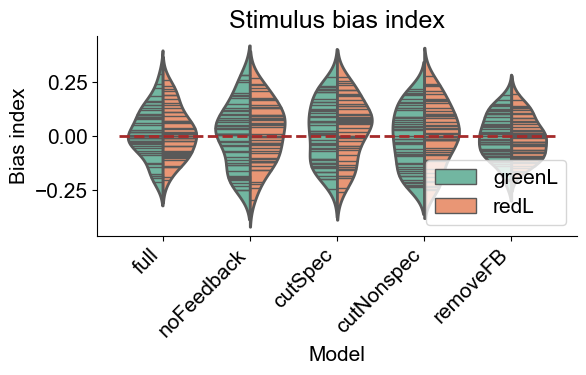

In [263]:
# all_stim_bias_df = pd.read_csv(os.path.join(data_dir, 'all_stim_bias.csv'))
# all_sac_bias_df = pd.read_csv(os.path.join(data_dir, 'all_sac_bias.csv'))

def plot_bias_index(df, save_fn=None, title=None):
    df = df.dropna()
    df.loc[:, 'label'] =  df['label'].str.split('_').str[1]

    fig, ax = plt.subplots()
    # pairs = [#(('full', 'redL'), ('full', 'greenL')), (('noFeedback', 'redL'), ('noFeedback', 'greenL')), (('cutSpec', 'redL'), ('cutSpec', 'greenL')), (('cutNonspec', 'redL'), ('cutNonspec', 'greenL')),
    #          (('full', 'redL'), ('noFeedback', 'redL')), (('full', 'redL'), ('cutSpec', 'redL')), (('full', 'redL'), ('cutNonspec', 'redL')), 
    #           (('full', 'greenL'), ('noFeedback', 'greenL')), (('full', 'greenL'), ('cutSpec', 'greenL')), (('full', 'greenL'), ('cutNonspec', 'greenL'))]
    # annot = Annotator(
    #     ax,
    #     pairs,
    #     data=df,
    #     x="model",
    #     y="bias",
    #     hue="label",
    # )
    # annot.configure(test="t-test_paired", text_format="star")
    # annot.apply_and_annotate()
    sns.violinplot(x='model', y='bias', hue='label', data=df, ax=ax, palette='Set2', split=True, inner='stick')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.hlines(0, -0.5, 4.5, linestyles='dashed', colors='brown')
    ax.set_ylabel('Bias index')
    ax.set_xlabel('Model')
    ax.set_title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    if save_fn is not None:
        plt.savefig(save_fn, dpi=300)
    plt.show()


plt_dir = "dPCA_allTrial_plots"
plot_bias_index(all_stim_bias_df, save_fn=os.path.join(plt_dir, 'stim_bias.png'), title='Stimulus bias index')

C:\Users\dell\AppData\Local\Temp\ipykernel_82404\2231531661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'label'] =  df['label'].str.split('_').str[1]


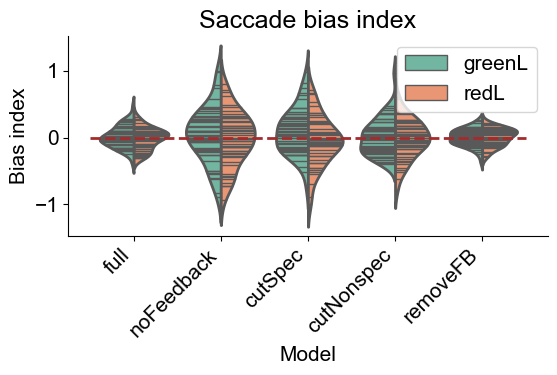

In [264]:
plt_dir = "dPCA_allTrial_plots"
plot_bias_index(all_sac_bias_df, save_fn=os.path.join(plt_dir, 'sac_bias.png'), title='Saccade bias index')

In [93]:
rep=0
n = SimpleNamespace(
    **load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep))
)
targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
y = n.y[:, targ_arrange==1, :]

In [94]:
np.where(y[-1, :, 1] > y[-1, :, 0])[0].shape

(269,)

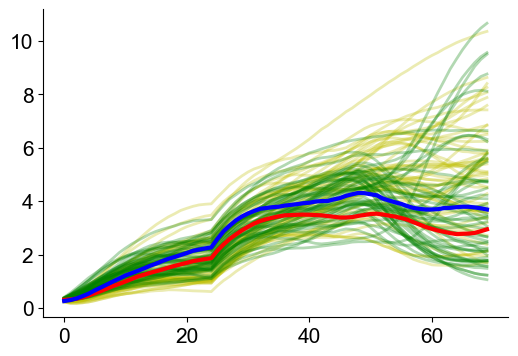

In [95]:
idx = np.random.randint(0, y.shape[1], size=(50,))
plt.plot(y[:, idx, 0], color='y', alpha=0.3)
plt.plot(y[:, idx, 1], color='g', alpha=0.3)

plt.plot(y[:, 471, 0], color='r', linewidth=3)
plt.plot(y[:, 471, 1], color='b', linewidth=3)
plt.show()

In [8]:

def plot_avgAct_combined(h, n, cell_idx, trial_idx, save_plt, mode, f_dir, m1=True):
    fig, ax = plt.subplots()
    coh_dict = find_coh_idx(n.stim_level)
    H_idx = coh_dict["H"]
    M_idx = coh_dict["M"]
    L_idx = coh_dict["L"]
    Z_idx = coh_dict["Z"]
    red_idx = n.stim_dir == 315
    green_idx = n.stim_dir == 135
    choice_color = get_choice_color(
        n.y, n.desired_out, n.stim_dir
    )  # return choice color (green = 0, red = 1)

    # plot lines
    colors = {
        "H_red": "#FF0000",
        "M_red": "#B30000",
        "L_red": "#660000",
        "H_green": "#00FF00",
        "M_green": "#00B300",
        "L_green": "#006600",
    }
    # zero coherence stimulus direction is based on the choice color
    if mode == "motion":
        if sum(Z_idx) != 0:
            ax.plot(
                np.mean(
                    h[19:, combine_idx(Z_idx, choice_color[-1, :] == 0), cell_idx],
                    axis=1,
                ),
                linestyle="--",
                color="#000000",
                label="135, Z",
            )
            ax.plot(
                np.mean(
                    h[19:, combine_idx(Z_idx, choice_color[-1, :] == 1), cell_idx],
                    axis=1,
                ),
                color="#000000",
                label="315, Z",
            )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, trial_idx, green_idx), cell_idx], axis=1
            ),
            color=colors["M_green"],
            label="135, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, trial_idx, green_idx), cell_idx], axis=1
            ),
            color=colors["L_green"],
            label="135, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, trial_idx, green_idx), cell_idx], axis=1
            ),
            color=colors["H_green"],
            label="135, H",
        )

        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, trial_idx, red_idx), cell_idx], axis=1
            ),
            color=colors["L_red"],
            label="315, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, trial_idx, red_idx), cell_idx], axis=1
            ),
            color=colors["M_red"],
            label="315, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, trial_idx, red_idx), cell_idx], axis=1
            ),
            color=colors["H_red"],
            label="315, H",
        )
    elif mode == "target":
        contra_idx, ipsi_idx = find_sac_idx(n.y, m1)
        if sum(Z_idx) != 0:
            ax.plot(
                np.mean(h[19:, combine_idx(Z_idx, contra_idx), cell_idx], axis=1),
                linestyle="--",
                color="#000000",
                label="contra sac, Z",
            )
            ax.plot(
                np.mean(h[19:, combine_idx(Z_idx, ipsi_idx), cell_idx], axis=1),
                color="#000000",
                label="ipsi sac, Z",
            )
        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, trial_idx, contra_idx), cell_idx], axis=1
            ),
            color=colors["L_green"],
            label="contra sac, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, trial_idx, contra_idx), cell_idx], axis=1
            ),
            color=colors["M_green"],
            label="contra sac, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, trial_idx, contra_idx), cell_idx], axis=1
            ),
            color=colors["H_green"],
            label="contra sac, H",
        )

        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, trial_idx, ipsi_idx), cell_idx], axis=1
            ),
            color=colors["L_red"],
            label="ipsi sac, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, trial_idx, ipsi_idx), cell_idx], axis=1
            ),
            color=colors["M_red"],
            label="ipsi sac, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, trial_idx, ipsi_idx), cell_idx], axis=1
            ),
            color=colors["H_red"],
            label="ipsi sac, H",
        )
    elif mode == "targ_arrange":
        if sum(Z_idx) != 0:
            ax.plot(
                np.mean(
                    h[19:, combine_idx(Z_idx, targ_arrange == 0), cell_idx],
                    axis=1,
                ),
                linestyle="--",
                color="#000000",
                label="targ_arr1, Z",
            )
            ax.plot(
                np.mean(
                    h[19:, combine_idx(Z_idx, targ_arrange == 1), cell_idx],
                    axis=1,
                ),
                color="#000000",
                label="targ_arr2, Z",
            )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, targ_arrange == 0), cell_idx], axis=1
            ),
            color=colors["M_green"],
            label="targ_arr1, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, targ_arrange == 0), cell_idx], axis=1
            ),
            color=colors["L_green"],
            label="targ_arr1, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, targ_arrange == 0), cell_idx], axis=1
            ),
            color=colors["H_green"],
            label="targ_arr1, H",
        )

        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx,  targ_arrange == 1), cell_idx], axis=1
            ),
            color=colors["L_red"],
            label="targ_arr2, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, targ_arrange == 1), cell_idx], axis=1
            ),
            color=colors["M_red"],
            label="targ_arr2, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, targ_arrange == 1), cell_idx], axis=1
            ),
            color=colors["H_red"],
            label="targ_arr2, H",
        )
    ax.set_xlim(0, 50)
    xticks = np.array([0, 25, 50])
    ax.set_xticks(xticks)
    ax.set_xticklabels((xticks + 20 - STIM_ST_TIME) * 20)

    ax.set_title("Cell %d, %s" % (cell_idx, mode))
    ax.set_ylabel("Average activity")
    ax.set_xlabel("Time")
    ax.axvline(x=TARG_ST_TIME - 20, color="k", alpha=0.8, linestyle="--", linewidth=1)
    ax.axvline(x=STIM_ST_TIME - 20, color="k", alpha=0.8, linestyle="--", linewidth=1)
    ax.legend(loc="best", prop={"size": 10}, frameon=False)
    plt.tight_layout()

    if save_plt:
        pic_dir = os.path.join(f_dir, "single_neuron_%s_activity_rep%d_combined" % (mode, rep))
        if not os.path.exists(pic_dir):
            os.makedirs(pic_dir)
        plt.savefig(os.path.join(pic_dir, "cell_%d.png" % cell_idx))
        # plt.savefig(os.path.join(pic_dir, "cell_%d.pdf" % cell_idx))
        plt.close(fig)


In [ ]:
motion_rng = np.concatenate((np.arange(0, 40), np.arange(80, 120), np.arange(160, 170), np.arange(180, 190)), axis=0)
target_rng = np.concatenate((np.arange(40, 80), np.arange(120, 160), np.arange(170, 180), np.arange(190, 200)), axis=0)
plt_dir = f_dir
# for i in range(200):
for i in target_rng:
    plot_avgAct_combined(n.h, n, i, range(200), True, mode='targ_arrange', f_dir=plt_dir)
#     plot_avgAct_combined(n.h, n, i, targ_arrange==1, True, mode='motion', f_dir=plt_dir)
# for i in range(200):
#     if i in np.concatenate((np.arange(0, 40), np.arange(40, 80), np.arange(160, 170), np.arange(170, 180))):
#         plot_avgAct_combined(n.h, n, i, targ_arrange==1, True, mode='target', f_dir=plt_dir,  m1=True)
#     else:
#         plot_avgAct_combined(n.h, n, i, targ_arrange==1, True, mode='target', f_dir=plt_dir, m1=False)

KeyboardInterrupt: 

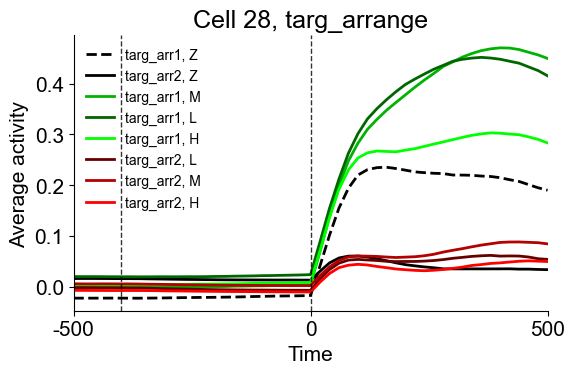

In [9]:
f_dir = 'test_output_full_model'
for rep in range(50):
    n = SimpleNamespace(
        **load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep))
    )
    targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
    motion_rng = np.concatenate((np.arange(0, 40), np.arange(80, 120), np.arange(160, 170), np.arange(180, 190)), axis=0)
    target_rng = np.concatenate((np.arange(40, 80), np.arange(120, 160), np.arange(170, 180), np.arange(190, 200)), axis=0)
    for i in range(200):
        plot_avgAct_combined(n.h, n, i, range(200), True, mode='targ_arrange', f_dir=f_dir)